In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\asgar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data from CSV
data = pd.read_csv('data.csv')

# Drop the timestamp
data = data.drop(['timestamp'], axis=1)

# Split data into 80% training and 20% testing
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Separate the testing data into normal (5%) and anomalies (15%)
normal_data = test_data.sample(frac=0.25, random_state=42)  # 5% normal (25% of 20%)
anomaly_data = test_data.drop(normal_data.index)  # Remaining 15% will be anomalies
y_true = np.concatenate([np.ones(len(normal_data)), np.zeros(len(anomaly_data))])

In [3]:
# Systematically introduce anomalies into the normal data
anomaly_data['ram_usage'] = anomaly_data['ram_usage'] * 1.25
anomaly_data['ram_usage'] = anomaly_data['ram_usage'].clip(upper=1.0)

anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'] * 1.50
anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'] * 1.60
anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'] * 1.30
anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'].clip(upper=1.0)

anomaly_data['network_bytes_sent'] = anomaly_data['network_bytes_sent'] * 1.10

In [4]:
# Combine back the normal and anomalous data for testing
test_data = pd.concat([normal_data, anomaly_data])

# List of columns that are already scaled and should not be scaled again
already_scaled_columns = ['cpu_usage', 'ram_usage', 'vram_usage', 'average_process_cpu_usage', 'average_process_ram_usage']

# Select columns that need scaling by excluding already scaled columns
columns_to_scale = [col for col in train_data.columns if col not in already_scaled_columns]

# Apply scaling only to the columns that need it
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

# Prepare the data
X_train = pd.concat([train_data[already_scaled_columns], train_data[columns_to_scale]], axis=1)
X_test = pd.concat([test_data[already_scaled_columns], test_data[columns_to_scale]], axis=1)

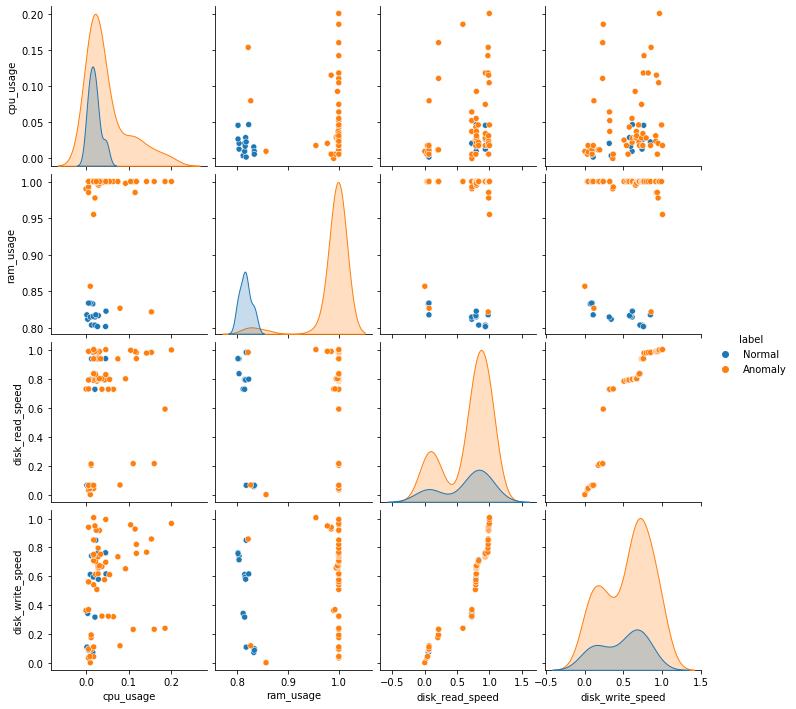

Confusion Matrix:
[[53  0]
 [ 3 15]]

---

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        53
         1.0       1.00      0.83      0.91        18

    accuracy                           0.96        71
   macro avg       0.97      0.92      0.94        71
weighted avg       0.96      0.96      0.96        71



In [5]:
# Initialize Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', random_state=42)

# Train the model on training data
iso_forest.fit(X_train)

# Predict anomalies on the test data
predictions = iso_forest.predict(X_test)

# Separate anomalies and normal data for visualization
anomalies = test_data[predictions == -1] # -1 for anomalies
normal = test_data[predictions == 1] # 1 for normal

# Combine normal and anomalies data with a label for easier plotting
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()

# Confusion Matrix
y_pred = np.where(predictions == 1, 1, 0)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\n---\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Best Parameters:
{'y_pred': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0]), 'n_estimators': 25, 'max_samples': 150, 'accuracy': 0.9577464788732394, 'precision': 1.0, 'recall': 0.8333333333333334, 'f1_score': 0.9090909090909091}

All Results:
    n_estimators  max_samples  accuracy  precision    recall  f1_score
0             25            5  0.394366   0.244898  0.666667  0.358209
1             25           10  0.873239   1.000000  0.500000  0.666667
2             25           20  0.887324   1.000000  0.555556  0.714286
3             25           40  0.887324   1.000000  0.555556  0.714286
4             25           50  0.901408   1.000000  0.611111  0.758621
5             25           75  0.915493   1.000000  0.666667  0.800000
6             25          100  0.929577   1.000000  0.722222  0.83

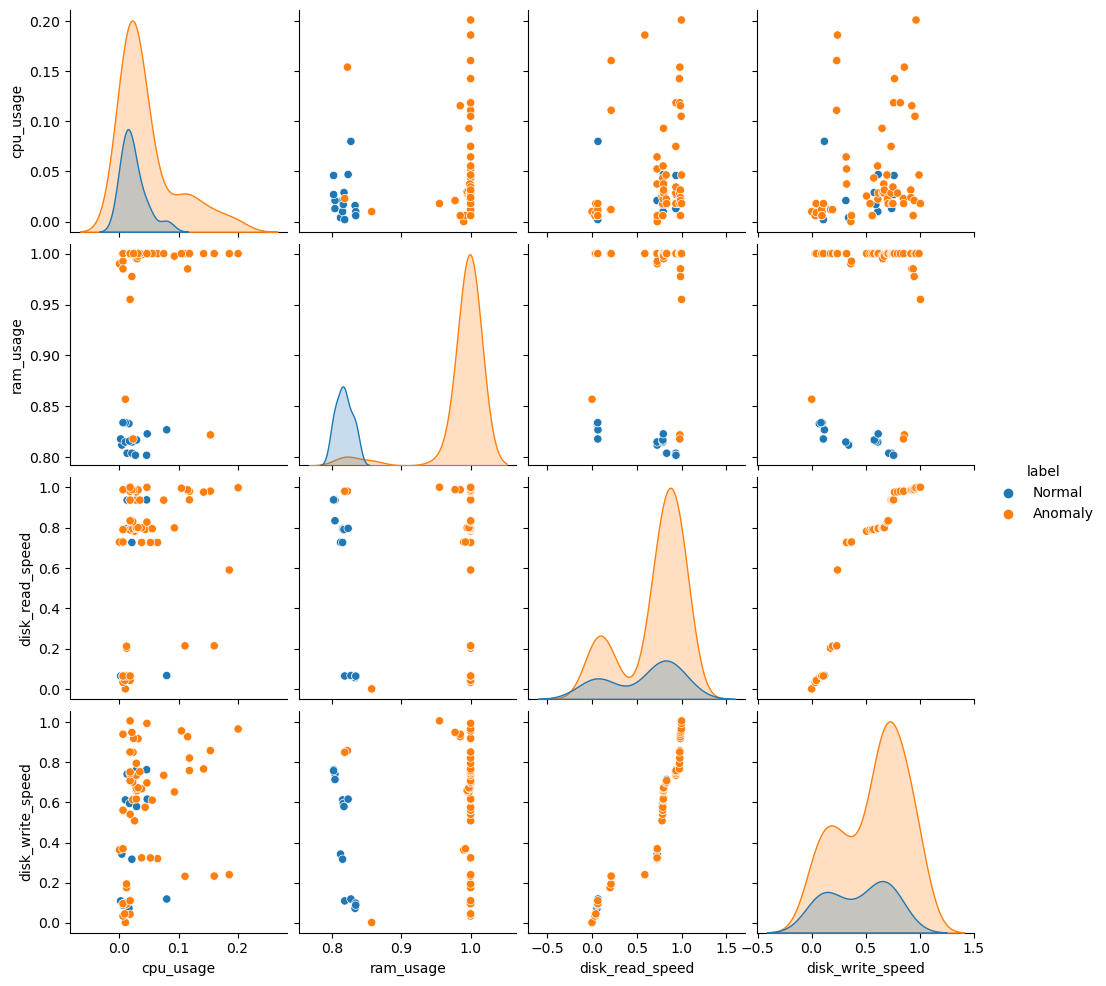

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


# Define ranges for hyperparameters
n_estimators_list = [25, 50, 100, 150]
max_samples_list = [5, 10, 20, 40, 50, 75, 100, 125, 150]

# Initialize results list
results = []
best_f1 = 0

for n_estimators in n_estimators_list:
    for max_samples in max_samples_list:
        # Initialize Isolation Forest model with current hyperparameters
        iso_forest = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            random_state=42
        )
        
        # Train the model
        iso_forest.fit(X_train)
        
        # Predict anomalies
        predictions = iso_forest.predict(X_test)
        y_pred = np.where(predictions == 1, 1, 0)
        
        conf_matrix = confusion_matrix(y_true, y_pred)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        results.append({
            'y_pred': y_pred,
            'n_estimators': n_estimators,
            'max_samples': max_samples,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'y_pred': y_pred,
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

# Print the best parameters
print("Best Parameters:")
print(best_params)

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.drop(['y_pred'], axis=1))

# Sort the DataFrame by 'f1_score' in descending order
results_df_sorted = results_df.sort_values(by='f1_score', ascending=False)

# Print the top results
print("\nTop Results:")
print(results_df_sorted.drop(['y_pred'], axis=1).head(35))

# Confusion Matrix of the best model
conf_matrix = confusion_matrix(y_true, best_params['y_pred'])
print("\nConfusion Matrix of the best model:")
print(conf_matrix)

# Pairplot of the best model
anomalies = test_data[best_params['y_pred'] == 0] # 0 for anomalies
normal = test_data[best_params['y_pred'] == 1] # 1 for normal
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()
